In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss

In [2]:
# Load the data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Task 3 and 4_Loan_Data.csv")
data.head()

Mounted at /content/drive


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
# Assuming the dataset has columns 'fico_score' and 'default'
fico_scores = data['fico_score']
defaults = data['default']

In [4]:
# Basic statistics and distribution
print(fico_scores.describe())
print(defaults.describe())

count    10000.000000
mean       637.557700
std         60.657906
min        408.000000
25%        597.000000
50%        638.000000
75%        679.000000
max        850.000000
Name: fico_score, dtype: float64
count    10000.000000
mean         0.185100
std          0.388398
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64


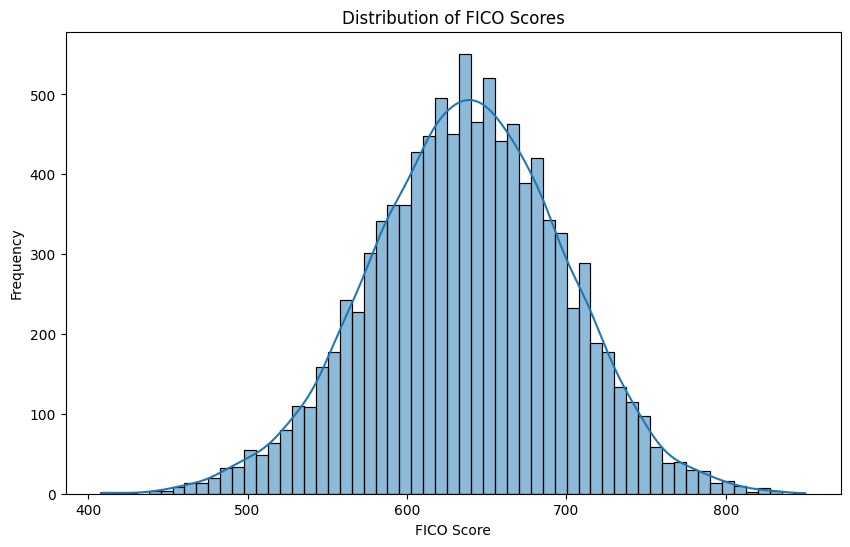

In [5]:
# Plot the distribution of FICO scores
plt.figure(figsize=(10, 6))
sns.histplot(fico_scores, kde=True)
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Mean square error minimization
def quantize_mse(fico_scores, n_buckets):
    # Calculate the bucket boundaries using quantiles
    boundaries = np.percentile(fico_scores, np.linspace(0, 100, n_buckets + 1))
    boundaries[-1] += 1  # Ensure the last boundary includes the max value

    # Assign FICO scores to buckets
    buckets = np.digitize(fico_scores, boundaries) - 1
    bucket_means = [fico_scores[buckets == i].mean() for i in range(n_buckets)]

    # Calculate the mean squared error
    mse = mean_squared_error(fico_scores, [bucket_means[i] for i in buckets])
    return boundaries, mse

n_buckets = 10
mse_boundaries, mse = quantize_mse(fico_scores, n_buckets)
print("MSE Boundaries:", mse_boundaries)
print("MSE:", mse)

MSE Boundaries: [408. 560. 587. 607. 623. 638. 653. 670. 688. 714. 851.]
MSE: 157.44789198655607


In [7]:
# Log likelihood maximization
def quantize_log_likelihood(fico_scores, defaults, n_buckets):
    # Calculate the bucket boundaries using quantiles
    boundaries = np.percentile(fico_scores, np.linspace(0, 100, n_buckets + 1))
    boundaries[-1] += 1  # Ensure the last boundary includes the max value

    # Assign FICO scores to buckets
    buckets = np.digitize(fico_scores, boundaries) - 1
    log_likelihood = 0

    for i in range(n_buckets):
        bucket_defaults = defaults[buckets == i]
        n_i = len(bucket_defaults)
        k_i = sum(bucket_defaults)
        p_i = k_i / n_i if n_i > 0 else 0.0
        if p_i > 0 and p_i < 1:
            log_likelihood += k_i * np.log(p_i) + (n_i - k_i) * np.log(1 - p_i)

    return boundaries, log_likelihood

log_likelihood_boundaries, log_likelihood = quantize_log_likelihood(fico_scores, defaults, n_buckets)
print("Log-Likelihood Boundaries:", log_likelihood_boundaries)
print("Log-Likelihood:", log_likelihood)

Log-Likelihood Boundaries: [408. 560. 587. 607. 623. 638. 653. 670. 688. 714. 851.]
Log-Likelihood: -4267.285160839691


<ipython-input-8-355ebd13a833>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bucket_summary, x='bucket', y='default_rate', palette='rocket')


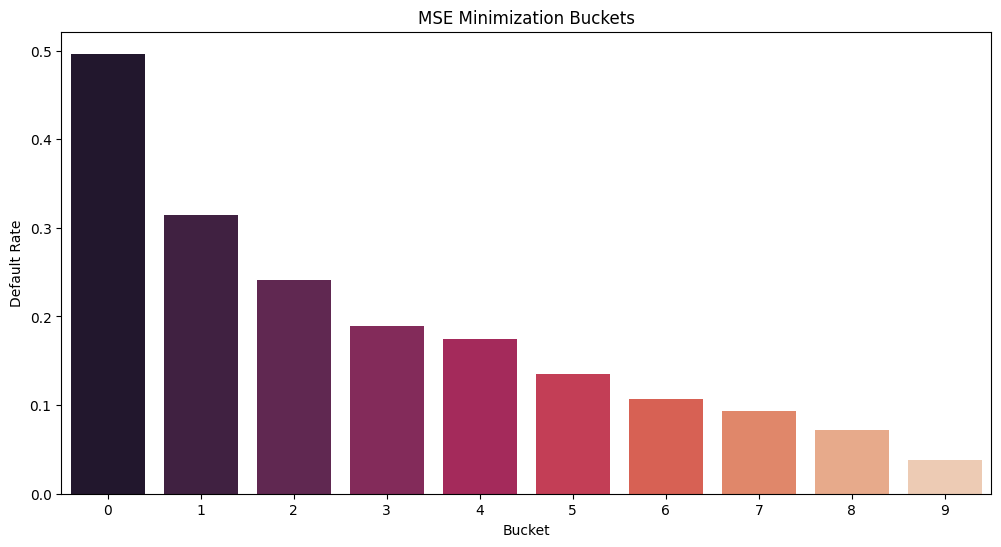

<ipython-input-8-355ebd13a833>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bucket_summary, x='bucket', y='default_rate', palette='rocket')


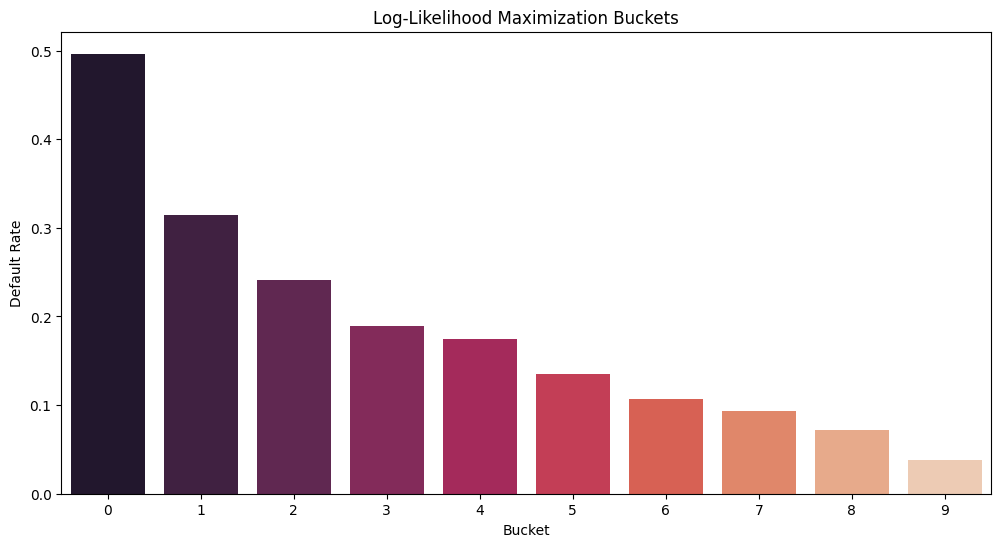

In [8]:
# Visualize the bucket boundaries and default rates
def plot_buckets(fico_scores, defaults, boundaries, title):
    buckets = np.digitize(fico_scores, boundaries) - 1
    bucket_data = pd.DataFrame({'bucket': buckets, 'default': defaults})
    bucket_summary = bucket_data.groupby('bucket').agg({'default': ['mean', 'count']}).reset_index()
    bucket_summary.columns = ['bucket', 'default_rate', 'count']

    plt.figure(figsize=(12, 6))
    sns.barplot(data=bucket_summary, x='bucket', y='default_rate', palette='rocket')
    plt.title(title)
    plt.xlabel('Bucket')
    plt.ylabel('Default Rate')
    plt.show()

# Plot the results for both quantization techniques
plot_buckets(fico_scores, defaults, mse_boundaries, 'MSE Minimization Buckets')
plot_buckets(fico_scores, defaults, log_likelihood_boundaries, 'Log-Likelihood Maximization Buckets')